# Redes Neuronales - Trabajo Práctico Final

Autor: Claudio Collado

*El trabajo práctico consiste en utilizar redes neuronales para clasificar música de acuerdo a su genero. Para esto analizaremos utilizaremos el Mel-frequency cepstral coefficients (MFCC) de fragmentos de 30 segundos. El mismo fue calculado librosa con el siguiente código:*

```
y, sr = librosa.load("musica.mp3")
spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
spect = librosa.power_to_db(spect, ref=np.max)
```

*La competencia está publicada en [Kaggle](https://www.kaggle.com/t/5b2b7dda7e64483e96af4c129d24420d).*


# 0. Librerías a utilizar.

In [1]:
#Libreria

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab import drive
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Concatenate,MaxPool2D,GlobalAvgPool2D,MaxPooling2D, BatchNormalization, GaussianNoise, GaussianDropout, Activation, Add,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

#Seteo de semilla
tf.random.set_seed(1234)

In [2]:
#Acceso a google drive donde tengo almacenados los datos

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Definimos donde van a estar tanto nuestro dataset como nuestro modelo. 

**IMPORTANTE**: Para facilitar la corrección definir los directorios de esta forma

In [3]:
data_path = '/content/drive/My Drive/DUIA-Redes-Neuronales/DatasetMusic/public/'
model_path = '/content/drive/My Drive/DUIA-Redes-Neuronales/DatasetMusic/sample/'

# 1. Archivos

### 1.1 CSV

En el dataset tenemos tres CSV:

* train.csv: archivo de entrenamiento. Contiene los ids de las canciones y su genero.
* test.csv: contiene los ids de las canciones que deben ser clasificadas.
* extra_features.csv: contiene features adicionales al MFCC. Este archivo contiene todas las canciones, tanto de entrada como de salida.

In [4]:
#Path para datasets de train, test y extra features

df_train = pd.read_csv(data_path + 'train.csv')
df_test = pd.read_csv(data_path + 'test.csv')
df_extra_features = pd.read_csv(data_path + 'extra_features.csv')

In [5]:
#5 primeras observaciones de train

df_train.head()

,track_id,genre
0,118063,4
1,138216,3
2,48864,1
3,72070,0
4,121452,0


In [6]:
#5 primeras observaciones de test

df_test.head()

,track_id
0,126557
1,89376
2,48440
3,140933
4,12352


In [7]:
#5 primeras observaciones de extra features

df_extra_features.head()

,track_id,"('chroma_cens', 'kurtosis', '01')","('chroma_cens', 'kurtosis', '02')","('chroma_cens', 'kurtosis', '03')","('chroma_cens', 'kurtosis', '04')","('chroma_cens', 'kurtosis', '05')","('chroma_cens', 'kurtosis', '06')","('chroma_cens', 'kurtosis', '07')","('chroma_cens', 'kurtosis', '08')","('chroma_cens', 'kurtosis', '09')","('chroma_cens', 'kurtosis', '10')","('chroma_cens', 'kurtosis', '11')","('chroma_cens', 'kurtosis', '12')","('chroma_cens', 'max', '01')","('chroma_cens', 'max', '02')","('chroma_cens', 'max', '03')","('chroma_cens', 'max', '04')","('chroma_cens', 'max', '05')","('chroma_cens', 'max', '06')","('chroma_cens', 'max', '07')","('chroma_cens', 'max', '08')","('chroma_cens', 'max', '09')","('chroma_cens', 'max', '10')","('chroma_cens', 'max', '11')","('chroma_cens', 'max', '12')","('chroma_cens', 'mean', '01')","('chroma_cens', 'mean', '02')","('chroma_cens', 'mean', '03')","('chroma_cens', 'mean', '04')","('chroma_cens', 'mean', '05')","('chroma_cens', 'mean', '06')","('chroma_cens', 'mean', '07')","('chroma_cens', 'mean', '08')","('chroma_cens', 'mean', '09')","('chroma_cens', 'mean', '10')","('chroma_cens', 'mean', '11')","('chroma_cens', 'mean', '12')","('chroma_cens', 'median', '01')","('chroma_cens', 'median', '02')","('chroma_cens', 'median', '03')",...,"('tonnetz', 'max', '04')","('tonnetz', 'max', '05')","('tonnetz', 'max', '06')","('tonnetz', 'mean', '01')","('tonnetz', 'mean', '02')","('tonnetz', 'mean', '03')","('tonnetz', 'mean', '04')","('tonnetz', 'mean', '05')","('tonnetz', 'mean', '06')","('tonnetz', 'median', '01')","('tonnetz', 'median', '02')","('tonnetz', 'median', '03')","('tonnetz', 'median', '04')","('tonnetz', 'median', '05')","('tonnetz', 'median', '06')","('tonnetz', 'min', '01')","('tonnetz', 'min', '02')","('tonnetz', 'min', '03')","('tonnetz', 'min', '04')","('tonnetz', 'min', '05')","('tonnetz', 'min', '06')","('tonnetz', 'skew', '01')","('tonnetz', 'skew', '02')","('tonnetz', 'skew', '03')","('tonnetz', 'skew', '04')","('tonnetz', 'skew', '05')","('tonnetz', 'skew', '06')","('tonnetz', 'std', '01')","('tonnetz', 'std', '02')","('tonnetz', 'std', '03')","('tonnetz', 'std', '04')","('tonnetz', 'std', '05')","('tonnetz', 'std', '06')","('zcr', 'kurtosis', '01')","('zcr', 'max', '01')","('zcr', 'mean', '01')","('zcr', 'median', '01')","('zcr', 'min', '01')","('zcr', 'skew', '01')","('zcr', 'std', '01')"
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,1.347792,1.237658,0.692500,0.569344,0.597041,0.625864,0.567330,0.443949,0.487976,0.497327,0.574435,0.579241,0.620102,0.586945,0.474300,0.369816,0.236119,0.228068,0.222830,0.221415,0.229238,0.248795,0.196245,0.175809,0.200713,0.319972,0.482825,0.387652,0.249082,...,0.318972,0.059690,0.069184,-0.002570,0.019296,0.010510,0.073464,0.009272,0.015765,-0.003789,0.017786,0.007311,0.067945,0.009488,0.016876,-0.059769,-0.091745,-0.185687,-0.140306,-0.048525,-0.089286,0.752462,0.262607,0.200944,0.593595,-0.177665,-1.424201,0.019809,0.029569,0.038974,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,0.268932,1.125141,0.611014,0.651471,0.494528,0.448799,0.468624,0.454021,0.497172,0.559755,0.671287,0.610565,0.551663,0.603413,0.258420,0.303385,0.250737,0.218562,0.245743,0.236018,0.275766,0.293982,0.346324,0.289821,0.246368,0.220939,0.255472,0.293571,0.245253,...,0.180027,0.072169,0.076847,-0.007501,-0.018525,-0.030318,0.024743,0.004771,-0.004536,-0.007385,-0.018953,-0.020358,0.024615,0.004868,-0.003899,-0.128391,-0.125289,-0.359463,-0.166667,-0.038546,-0.146136,1.212025,0.218381,-0.419971,-0.014541,-0.199314,-0.925733,0.025550,0.021106,0.084997,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
2,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,4.326824,1.300406,0.461840,0.540411,0

### 1.2 Archivos npz
Los archivos npz son archivos de numpy comprimidos. En este caso tenemos dos archivos:
* processed.npz: El archivo posee 3 arreglos numpy
    * x_train: un arreglo numpy de 3 dimesiones con los MFCC de las canciones de entrenamiento ordenadas como están ordenadas en el train.csv.
    * y_train: los labels para las canciones.
    * x_test:  un arreglo numpy de 3 dimesiones con los MFCC de las canciones de testing ordenadas como están ordenadas en el test.csv.
* music.npz: los MFCC de todas las canciones indexadas por el track id en formato string de 6 dígitos. Si el id se representa con menos de 6 dígitos se completa a la izquierda con ceros. Por ejemplo, el track_id 2 está representado como el string `'000002'`.

In [8]:
ds = np.load(data_path + 'processed.npz')
x = ds['x_train']
y = ds['y_train']
x_test = ds['x_test']
print(x.shape)
del ds

(6395, 128, 1290)


### 1.3 MFCC

Graficamos para ver un ejemplo del MFCC. Importante en el MFCC la segunda dimensión es el tiempo.

**Importante:** los x tienen forma Instancias x Coheficientes MFCC x Tiempo.

**Importante 2:** Si se analiza con lógica temporal es necesario transponer el MFCC.

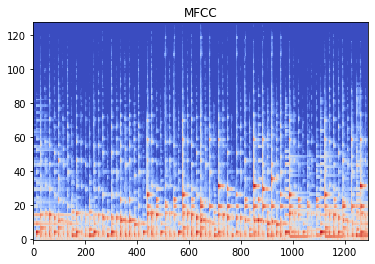

3.8146973e-06
-80.0


In [9]:
ig, ax = plt.subplots()
cax = ax.imshow(x[0,...], interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC')
#Showing mfcc_data
plt.show()
print(np.max(x))
print(np.min(x))

## 2. Preparacion de los datos

*   Para entrenar el código, como primera medida dividimos el dataset de entrenamiento en training y validation (development). El objetivo de esto es poder tener una evaluación de nuestro modelo para detectar problemas como overfitting antes de hacer un submit.
*   Para evitar problemas de memoria vamos eliminando lo que no vamos a volver a usar, como `x` o `y`.
*   También normalizamos de 0 a 1, y agregamos una dimensión para representar el canal.


In [10]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
del x
del y
x_train = np.expand_dims(x_train, axis=-1) / -80
x_val = np.expand_dims(x_val, axis=-1) / -80
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

x_test = np.expand_dims(x_test, axis=-1) / -80

# 3. Modelos

*   Se considero utilizar Redes Neuronales Convolucionales (CNN) sobre la representacion MFCC. Sobre este tipo de arquitecturas se exploraron 8 modelos
*   El mejor resultado obtenido corresponde al Modelo N°7 con un score publico de 0.52818




### 3.1 Modelo N° 1

Se tomo como base el modelo provisto en el Notebooks correspondiente a "Sample Benchmark":

Public Score: 0.37160

In [11]:
i1 = Input((128, 500, 1))
c1 = Conv2D(32, (5,5), activation='relu')(i1) #Capa convolucional
c1 = Conv2D(32, (5,5), activation='relu')(c1) #Capa convolucional
c1 = MaxPool2D()(c1) #Capa Max pooling
c1 = Conv2D(64, (5,5), activation='relu')(c1) #Capa convolucional
c1 = Conv2D(64, (5,5), activation='relu')(c1) #Capa convolucional
c1 = MaxPool2D()(c1) #Capa Max pooling
c1 = Conv2D(128, (5,5), activation='relu')(c1) #Capa convolucional
c1 = Conv2D(128, (5,5), activation='relu')(c1) #Capa convolucional
c1 = GlobalAvgPool2D()(c1) #Capa Average pooling
c1 = Dense(8, activation='softmax')(c1) #Capa final softmax

#Modelo instanciado y resumen
model1 = Model(i1, c1)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-4), 
              metrics=['sparse_categorical_accuracy'])
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 500, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 496, 32)      832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 492, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 246, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 242, 64)       51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 238, 64)       102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 119, 64)       0     

In [ ]:
#Entrenamiento y guardado del modelo

if not os.path.exists(model_path + 'sample_model.h1'):
    model1.fit(x_train[:, :,500:1000, :], y_train, epochs=10, validation_data=(x_val[:, :,500:1000, :], y_val))
    model1.save(model_path + 'sample_model.h1')

Epoch 1/20
160/160 [==============================] - 104s 429ms/step - loss: 2.0682 - sparse_categorical_accuracy: 0.1343 - val_loss: 2.0544 - val_sparse_categorical_accuracy: 0.1486
Epoch 2/20
160/160 [==============================] - 59s 370ms/step - loss: 1.9965 - sparse_categorical_accuracy: 0.2107 - val_loss: 1.9253 - val_sparse_categorical_accuracy: 0.3018
Epoch 3/20
160/160 [==============================] - 59s 370ms/step - loss: 1.9145 - sparse_categorical_accuracy: 0.2803 - val_loss: 1.8786 - val_sparse_categorical_accuracy: 0.2713
Epoch 4/20
160/160 [==============================] - 59s 370ms/step - loss: 1.8508 - sparse_categorical_accuracy: 0.3079 - val_loss: 1.7880 - val_sparse_categorical_accuracy: 0.3135
Epoch 5/20
160/160 [==============================] - 59s 370ms/step - loss: 1.8123 - sparse_categorical_accuracy: 0.3172 - val_loss: 1.8795 - val_sparse_categorical_accuracy: 0.2533
Epoch 6/20
160/160 [==============================] - 59s 370ms/step - loss: 1.7931 

In [ ]:
#Predicciones

model1 = keras.models.load_model(model_path + 'sample_model.h1')
y_pred1 = np.argmax(model1.predict(x_test[:, :, 500:1000, :]), axis=-1)
prediction1 = df_test['track_id'].to_frame()
prediction1['genre'] = y_pred1
prediction1.to_csv(model_path + 'sample_predictions1.csv', index=False)
prediction1.head()

,track_id,genre
0,126557,4
1,89376,1
2,48440,0
3,140933,0
4,12352,7


In [ ]:
#Liberacion de memoria

del model1
del i1
del c1

### 3.2 Modelo N°2

Se tomo como base el modelo provisto en el Notebooks correspondiente a "Sample Benchmark" y solo se modifico la cantidad de epochs con las cuales fue entrenado (20)

Public Score: 0.41544

In [ ]:
i2 = Input((128, 500, 1))
c2 = Conv2D(32, (5,5), activation='relu')(i2) #Capa convolucional
c2 = Conv2D(32, (5,5), activation='relu')(c2) #Capa convolucional
c2 = MaxPool2D()(c2) #Capa Max pooling
c2 = Conv2D(64, (5,5), activation='relu')(c2) #Capa convolucional
c2 = Conv2D(64, (5,5), activation='relu')(c2) #Capa convolucional
c2 = MaxPool2D()(c2) #Capa Max pooling
c2 = Conv2D(128, (5,5), activation='relu')(c2) #Capa convolucional
c2 = Conv2D(128, (5,5), activation='relu')(c2) #Capa convolucional
c2 = GlobalAvgPool2D()(c2) #Capa Average pooling
c2 = Dense(8, activation='softmax')(c2) #Capa final softmax

#Modelo instanciado y resumen
model2 = Model(i2, c2)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-4), 
              metrics=['sparse_categorical_accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 500, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 124, 496, 32)      832       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 120, 492, 32)      25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 246, 32)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 242, 64)       51264     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 238, 64)       102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 119, 64)       0   

In [ ]:
#Entrenamiento y guardado del modelo

if not os.path.exists(model_path + 'sample_model.h2'):
    model2.fit(x_train[:, :,500:1000, :], y_train, epochs=20, validation_data=(x_val[:, :,500:1000, :], y_val))
    model2.save(model_path + 'sample_model.h2')

Epoch 1/20
160/160 [==============================] - 104s 429ms/step - loss: 2.0682 - sparse_categorical_accuracy: 0.1343 - val_loss: 2.0544 - val_sparse_categorical_accuracy: 0.1486
Epoch 2/20
160/160 [==============================] - 59s 370ms/step - loss: 1.9965 - sparse_categorical_accuracy: 0.2107 - val_loss: 1.9253 - val_sparse_categorical_accuracy: 0.3018
Epoch 3/20
160/160 [==============================] - 59s 370ms/step - loss: 1.9145 - sparse_categorical_accuracy: 0.2803 - val_loss: 1.8786 - val_sparse_categorical_accuracy: 0.2713
Epoch 4/20
160/160 [==============================] - 59s 370ms/step - loss: 1.8508 - sparse_categorical_accuracy: 0.3079 - val_loss: 1.7880 - val_sparse_categorical_accuracy: 0.3135
Epoch 5/20
160/160 [==============================] - 59s 370ms/step - loss: 1.8123 - sparse_categorical_accuracy: 0.3172 - val_loss: 1.8795 - val_sparse_categorical_accuracy: 0.2533
Epoch 6/20
160/160 [==============================] - 59s 370ms/step - loss: 1.7931 

In [ ]:
#Predicciones

model2 = keras.models.load_model(model_path + 'sample_model.h2')
y_pred2 = np.argmax(model2.predict(x_test[:, :, 500:1000, :]), axis=-1)
prediction2 = df_test['track_id'].to_frame()
prediction2['genre'] = y_pred2
prediction2.to_csv(model_path + 'sample_predictions2.csv', index=False)
prediction2.head()

,track_id,genre
0,126557,4
1,89376,1
2,48440,0
3,140933,0
4,12352,7


In [ ]:
#Liberacion de memoria

del model2
del i2
del c2

### 3.3 Modelo N°3

Se tomo como base el Modelo N°2:

*   Se agrego una capa de Max Pooling antes de Gloval Average Pooling 
*   Se agrego una capa densa de 128 neuronas antes de la capa final Softmax

Public Score: 0.45511

In [ ]:
i3 = Input((128, 500, 1))
c3 = Conv2D(32, (5,5), activation='relu')(i3) #Capa convolucional
c3 = Conv2D(32, (5,5), activation='relu')(c3) #Capa convolucional
c3 = MaxPool2D()(c3) #Capa Max pooling
c3 = Conv2D(64, (5,5), activation='relu')(c3) #Capa convolucional
c3 = Conv2D(64, (5,5), activation='relu')(c3) #Capa convolucional
c3 = MaxPool2D()(c3) #Capa Max pooling
c3 = Conv2D(128, (5,5), activation='relu')(c3) #Capa convolucional
c3 = Conv2D(128, (5,5), activation='relu')(c3) #Capa convolucional
c3 = MaxPool2D()(c3) #Capa Max pooling
c3 = GlobalAvgPool2D()(c3) #Capa Average pooling
c3 = Flatten()(c3)
c3 = Dense(128, activation='relu')(c3) #Capa densa
c3 = Dense(8, activation='softmax')(c3) #Capa final softmax

#Modelo instanciado y resumen
model3 = Model(i3, c3)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-4), 
              metrics=['sparse_categorical_accuracy'])
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 500, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 496, 32)      832       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 120, 492, 32)      25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 60, 246, 32)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 242, 64)       51264     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 52, 238, 64)       102464    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 119, 64)       0   

In [ ]:
#Entrenamiento y guardado del modelo

if not os.path.exists(model_path + 'sample_model.h3'):
    model3.fit(x_train[:, :,500:1000, :], y_train, epochs=20, validation_data=(x_val[:, :,500:1000, :], y_val))
    model3.save(model_path + 'sample_model.h3')

Epoch 1/20
160/160 [==============================] - 60s 368ms/step - loss: 2.0768 - sparse_categorical_accuracy: 0.1259 - val_loss: 2.0660 - val_sparse_categorical_accuracy: 0.2088
Epoch 2/20
160/160 [==============================] - 59s 368ms/step - loss: 2.0207 - sparse_categorical_accuracy: 0.1871 - val_loss: 1.9327 - val_sparse_categorical_accuracy: 0.2541
Epoch 3/20
160/160 [==============================] - 59s 370ms/step - loss: 1.9221 - sparse_categorical_accuracy: 0.2672 - val_loss: 1.8910 - val_sparse_categorical_accuracy: 0.2557
Epoch 4/20
160/160 [==============================] - 59s 370ms/step - loss: 1.8419 - sparse_categorical_accuracy: 0.3112 - val_loss: 1.7789 - val_sparse_categorical_accuracy: 0.3253
Epoch 5/20
160/160 [==============================] - 59s 370ms/step - loss: 1.7994 - sparse_categorical_accuracy: 0.3186 - val_loss: 1.8442 - val_sparse_categorical_accuracy: 0.2737
Epoch 6/20
160/160 [==============================] - 59s 370ms/step - loss: 1.7752 -

In [ ]:
#Predicciones

model3 = keras.models.load_model(model_path + 'sample_model.h3')
y_pred3 = np.argmax(model3.predict(x_test[:, :, 500:1000, :]), axis=-1)
prediction3 = df_test['track_id'].to_frame()
prediction3['genre'] = y_pred3
prediction3.to_csv(model_path + 'sample_predictions3.csv', index=False)
prediction3.head()

,track_id,genre
0,126557,4
1,89376,1
2,48440,3
3,140933,5
4,12352,7


In [ ]:
#Liberacion de memoria

del model3
del i3
del c3

### 3.4 Modelo N°4

Se tomo como base el Modelo N°3:

*   Se agregaron capas BatchNormalization() luego de cada MaxPool2D()


Public Score: 0.51565

In [ ]:
i4 = Input((128, 500, 1))
c4 = Conv2D(32, (5,5), activation='relu')(i4) #Capa convolucional
c4 = Conv2D(32, (5,5), activation='relu')(c4) #Capa convolucional
c4 = MaxPool2D()(c4) #Capa Max pooling
c4 = BatchNormalization()(c4) #Capa de normalizacion
c4 = Conv2D(64, (5,5), activation='relu')(c4) #Capa convolucional
c4 = Conv2D(64, (5,5), activation='relu')(c4) #Capa convolucional
c4 = MaxPool2D()(c4) #Capa Max pooling
c4 = BatchNormalization()(c4) #Capa de normalizacion
c4  = Conv2D(128, (5,5), activation='relu')(c4) #Capa convolucional
c4 = Conv2D(128, (5,5), activation='relu')(c4) #Capa convolucional
c4 = MaxPool2D()(c4) #Capa Max pooling
c4 = BatchNormalization()(c4) #Capa de normalizacion
c4 = GlobalAvgPool2D()(c4) #Capa Average pooling
c4 = Flatten()(c4)
c4 = Dense(128, activation='relu')(c4) #Capa densa
c4 = Dense(8, activation='softmax')(c4) #Capa final softmax

#Modelo instanciado y resumen
model4 = Model(i4, c4)
model4.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-4), 
              metrics=['sparse_categorical_accuracy'])
model4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 500, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 496, 32)      832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 492, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 246, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 246, 32)       128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 242, 64)       51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 238, 64)       102464

In [ ]:
#Entrenamiento y guardado del modelo

if not os.path.exists(model_path + 'sample_model.h4'):
    model4.fit(x_train[:, :,500:1000, :], y_train, epochs=20, validation_data=(x_val[:, :,500:1000, :], y_val))
    model4.save(model_path + 'sample_model.h4')

Epoch 1/20
160/160 [==============================] - 112s 472ms/step - loss: 1.7354 - sparse_categorical_accuracy: 0.3735 - val_loss: 2.1901 - val_sparse_categorical_accuracy: 0.1251
Epoch 2/20
160/160 [==============================] - 64s 400ms/step - loss: 1.5494 - sparse_categorical_accuracy: 0.4492 - val_loss: 2.6840 - val_sparse_categorical_accuracy: 0.1251
Epoch 3/20
160/160 [==============================] - 64s 400ms/step - loss: 1.4682 - sparse_categorical_accuracy: 0.4799 - val_loss: 3.0091 - val_sparse_categorical_accuracy: 0.1360
Epoch 4/20
160/160 [==============================] - 64s 400ms/step - loss: 1.3866 - sparse_categorical_accuracy: 0.5186 - val_loss: 1.9802 - val_sparse_categorical_accuracy: 0.2979
Epoch 5/20
160/160 [==============================] - 64s 401ms/step - loss: 1.3375 - sparse_categorical_accuracy: 0.5379 - val_loss: 1.6357 - val_sparse_categorical_accuracy: 0.4019
Epoch 6/20
160/160 [==============================] - 64s 400ms/step - loss: 1.2851 

In [ ]:
#Predicciones

model4 = keras.models.load_model(model_path + 'sample_model.h4')
y_pred4 = np.argmax(model4.predict(x_test[:, :, 500:1000, :]), axis=-1)
prediction4 = df_test['track_id'].to_frame()
prediction4['genre'] = y_pred4
prediction4.to_csv(model_path + 'sample_predictions4.csv', index=False)
prediction4.head()

,track_id,genre
0,126557,0
1,89376,1
2,48440,1
3,140933,0
4,12352,6


In [ ]:
#Liberacion de memoria

del model4
del i4
del c4

### 3.5 Modelo N°5

Se tomo como base el Modelo N°4:

*   Se utilizo un tamaño de vector de entrada mayor (800)


Public Score: 0.51983

In [ ]:
i5 = Input((128, 800, 1)) #Vector de entrada de tamaño 800
c5 = Conv2D(32, (5,5), activation='relu')(i5) #Capa convolucional
c5 = Conv2D(32, (5,5), activation='relu')(c5) #Capa convolucional
c5 = MaxPool2D()(c5) #Capa Max pooling
c5 = BatchNormalization()(c5) #Capa de normalizacion
c5 = Conv2D(64, (5,5), activation='relu')(c5) #Capa convolucional
c5 = Conv2D(64, (5,5), activation='relu')(c5) #Capa convolucional
c5 = MaxPool2D()(c5) #Capa Max pooling
c5 = BatchNormalization()(c5) #Capa de normalizacion
c5 = Conv2D(128, (5,5), activation='relu')(c5) #Capa convolucional
c5 = Conv2D(128, (5,5), activation='relu')(c5) #Capa convolucional
c5 = MaxPool2D()(c5) #Capa Max pooling
c5 = BatchNormalization()(c5) #Capa de normalizacion
c5 = GlobalAvgPool2D()(c5) #Capa Average pooling
c5 = Flatten()(c5)
c5 = Dense(128, activation='relu')(c5) #Capa densa
c5 = Dense(8, activation='softmax')(c5) #Capa final softmax

#Modelo instanciado y resumen
model5 = Model(i5, c5)
model5.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-4), 
              metrics=['sparse_categorical_accuracy'])
model5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 800, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 796, 32)      832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 792, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 396, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 396, 32)       128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 392, 64)       51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 388, 64)       102464

In [ ]:
#Entrenamiento y guardado del modelo

if not os.path.exists(model_path + 'sample_model.h5'):
    model5.fit(x_train[:, :,200:1000, :], y_train, epochs=20, validation_data=(x_val[:, :,200:1000, :], y_val))
    model5.save(model_path + 'sample_model.h5')

Epoch 1/20
160/160 [==============================] - 151s 695ms/step - loss: 1.7215 - sparse_categorical_accuracy: 0.3767 - val_loss: 2.1733 - val_sparse_categorical_accuracy: 0.1243
Epoch 2/20
160/160 [==============================] - 97s 608ms/step - loss: 1.5350 - sparse_categorical_accuracy: 0.4564 - val_loss: 2.8163 - val_sparse_categorical_accuracy: 0.1689
Epoch 3/20
160/160 [==============================] - 97s 608ms/step - loss: 1.4513 - sparse_categorical_accuracy: 0.4865 - val_loss: 2.9340 - val_sparse_categorical_accuracy: 0.1603
Epoch 4/20
160/160 [==============================] - 97s 608ms/step - loss: 1.3688 - sparse_categorical_accuracy: 0.5235 - val_loss: 2.1172 - val_sparse_categorical_accuracy: 0.2220
Epoch 5/20
160/160 [==============================] - 97s 608ms/step - loss: 1.3145 - sparse_categorical_accuracy: 0.5481 - val_loss: 1.7446 - val_sparse_categorical_accuracy: 0.3034
Epoch 6/20
160/160 [==============================] - 97s 608ms/step - loss: 1.2727 

In [ ]:
#Predicciones

model5 = keras.models.load_model(model_path + 'sample_model.h5')
y_pred5 = np.argmax(model5.predict(x_test[:, :, 200:1000, :]), axis=-1)
prediction5 = df_test['track_id'].to_frame()
prediction5['genre'] = y_pred5
prediction5.to_csv(model_path + 'sample_predictions5.csv', index=False)
prediction5.head()

,track_id,genre
0,126557,0
1,89376,1
2,48440,0
3,140933,0
4,12352,1


In [ ]:
#Liberacion de memoria

del model5
del i5
del c5

### 3.6 Modelo N°6

Se tomo como base el Modelo N°5:

*   Se agregaron capas convolucionales al inicio y final y se modifico el tamaño de los filtros
*   Se agrego Dropout luego de cada bloque de convolucion / Pooling / Normalizacion
*   Se amplio la cantidad de neuronas (512) de la capa densa previa a la capa final Softmax
*   Se amplio la cantidad de epochs


Public Score: 0.51983

In [ ]:
i6 = Input((128, 500, 1))
c6 = Conv2D(16, (3, 3),activation='relu',strides=(1, 1), padding='same')(i6) #Capa convolucional
c6 = MaxPool2D()(c6) #Capa Max pooling
c6 = BatchNormalization()(c6) #Capa de normalizacion
c6 = Dropout(0.25)(c6) #Capa Dropout
c6 = Conv2D(32, (3, 3),activation='relu',strides=(1, 1), padding='same')(c6) #Capa convolucional
c6 = MaxPool2D()(c6) #Capa Max pooling
c6 = BatchNormalization()(c6) #Capa de normalizacion
c6 = Dropout(0.25)(c6) #Capa Dropout
c6 = Conv2D(64, (3, 3),activation='relu',strides=(1, 1), padding='same')(c6) #Capa convolucional
c6 = MaxPool2D()(c6) #Capa Max pooling
c6 = BatchNormalization()(c6) #Capa de normalizacion
c6 = Dropout(0.25)(c6) #Capa Dropout
c6 = Conv2D(128, (3, 3),activation='relu',strides=(1, 1), padding='same')(c6) #Capa convolucional
c6 = MaxPool2D()(c6) #Capa Max pooling
c6 = BatchNormalization()(c6) #Capa de normalizacion
c6 = Dropout(0.25)(c6) #Capa Dropout
c6 = Conv2D(256, (3, 3),activation='relu',strides=(1, 1), padding='same')(c6) #Capa convolucional
c6 = MaxPool2D()(c6) #Capa Max pooling
c6 = BatchNormalization()(c6) #Capa de normalizacion
c6 = Dropout(0.25)(c6) #Capa Dropout
c6 = Flatten()(c6)
c6 = Dropout(0.5)(c6) #Capa Dropout
c6 = Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02))(c6) #Capa densa
c6 = Dropout(0.5)(c6) #Capa Dropout
c6 = Dense(8, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.02))(c6) #Capa final softmax

#Modelo instanciado y resumen
model6 = Model(i6, c6)
model6.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-4), 
              metrics=['sparse_categorical_accuracy'])
model6.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 500, 1)]     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 500, 16)      160       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 250, 16)       0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 64, 250, 16)       64        
_________________________________________________________________
dropout_35 (Dropout)         (None, 64, 250, 16)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 250, 32)       4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 125, 32)       0   

In [ ]:
#Entrenamiento y guardado del modelo

if not os.path.exists(model_path + 'sample_model.h6'):
    model6.fit(x_train[:, :,500:1000, :], y_train, epochs=150, validation_data=(x_val[:, :,500:1000, :], y_val))
    model6.save(model_path + 'sample_model.h6')

In [ ]:
#Predicciones

model6 = keras.models.load_model(model_path + 'sample_model.h6')
y_pred6 = np.argmax(model6.predict(x_test[:, :, 500:1000, :]), axis=-1)
prediction6 = df_test['track_id'].to_frame()
prediction6['genre'] = y_pred6
prediction6.to_csv(model_path + 'sample_predictions6.csv', index=False)
prediction6.head()

,track_id,genre
0,126557,4
1,89376,1
2,48440,0
3,140933,0
4,12352,2


In [ ]:
#Liberacion de memoria

del model6
del i6
del c6

### 3.7 Modelo N°7

Se tomo como base el Modelo N°6:

*   Se redujo el valor de Dropout luego de cada bloque de convolucion / Pooling / Normalizacion
*   Se incorporo una capa de ruido gausiano luego de cada capa Max Pooling

Public Score: 0.52818 (mejor score obtenido)

In [ ]:
i7 = Input((128, 500, 1))
c7 = Conv2D(16, (3, 3),activation='relu',strides=(1, 1), padding='same')(i7) #Capa convolucional
c7 = MaxPool2D()(c7) #Capa Max pooling
c7 = BatchNormalization()(c7) #Capa de normalizacion
c7 = Dropout(0.25)(c7) #Capa Dropout
c7 = Conv2D(32, (3, 3),activation='relu',strides=(1, 1), padding='same')(c7) #Capa convolucional
c7 = MaxPool2D()(c7) #Capa Max pooling
c7 = GaussianNoise(0.1) (c7) #Capa ruido gaussiano
c7 = BatchNormalization()(c7) #Capa de normalizacion
c7 = Dropout(0.25)(c7) #Capa Dropout
c7 = Conv2D(64, (3, 3),activation='relu',strides=(1, 1), padding='same')(c7) #Capa convolucional
c7 = MaxPool2D()(c7) #Capa Max pooling
c7 = GaussianNoise(0.1) (c7) #Capa ruido gaussiano
c7 = BatchNormalization()(c7) #Capa de normalizacion
c7 = Dropout(0.25)(c7) #Capa Dropout
c7 = Conv2D(128, (3, 3),activation='relu',strides=(1, 1), padding='same')(c7) #Capa convolucional
c7 = MaxPool2D()(c7) #Capa Max pooling
c7 = GaussianNoise(0.1) (c7) #Capa ruido gaussiano
c7 = BatchNormalization()(c7) #Capa de normalizacion
c7 = Dropout(0.25)(c7) #Capa Dropout
c7 = Conv2D(256, (3, 3),activation='relu',strides=(1, 1), padding='same')(c7) #Capa convolucional
c7 = MaxPool2D()(c7) #Capa Max pooling
c7 = GaussianNoise(0.1) (c7) #Capa ruido gaussiano
c7 = BatchNormalization()(c7) #Capa de normalizacion
c7 = GlobalAvgPool2D()(c7) #Capa Average pooling
c7 = Dropout(0.25)(c7) #Capa Dropout
c7 = Flatten()(c7)
c7 = Dropout(0.5)(c7) #Capa Dropout
c7 = Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02))(c7) #Capa Densa con regularizacion
c7 = Dropout(0.5)(c7) #Capa Dropout
c7 = Dense(8, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.02))(c7) #Capa final softmax

#Modelo instanciado y resumen
model7 = Model(i7, c7)
model7.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-4), 
              metrics=['sparse_categorical_accuracy'])
model7.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 500, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 500, 16)      160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 250, 16)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 250, 16)       64        
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 250, 16)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 250, 32)       4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 125, 32)       0   

In [ ]:
#Entrenamiento y guardado del modelo

if not os.path.exists(model_path + 'sample_model.h7'):
    model7.fit(x_train[:, :,500:1000, :], y_train, epochs=150, validation_data=(x_val[:, :,500:1000, :], y_val))
    model7.save(model_path + 'sample_model.h7')

Epoch 1/150
160/160 [==============================] - 50s 115ms/step - loss: 8.3204 - sparse_categorical_accuracy: 0.2652 - val_loss: 8.0106 - val_sparse_categorical_accuracy: 0.1251
Epoch 2/150
160/160 [==============================] - 16s 103ms/step - loss: 6.8677 - sparse_categorical_accuracy: 0.3479 - val_loss: 7.5755 - val_sparse_categorical_accuracy: 0.1251
Epoch 3/150
160/160 [==============================] - 16s 103ms/step - loss: 5.7848 - sparse_categorical_accuracy: 0.3599 - val_loss: 6.7521 - val_sparse_categorical_accuracy: 0.1251
Epoch 4/150
160/160 [==============================] - 16s 103ms/step - loss: 4.9066 - sparse_categorical_accuracy: 0.3888 - val_loss: 6.3097 - val_sparse_categorical_accuracy: 0.1251
Epoch 5/150
160/160 [==============================] - 17s 103ms/step - loss: 4.1961 - sparse_categorical_accuracy: 0.4150 - val_loss: 4.9815 - val_sparse_categorical_accuracy: 0.1345
Epoch 6/150
160/160 [==============================] - 16s 103ms/step - loss: 3.

In [ ]:
#Predicciones

model7 = keras.models.load_model(model_path + 'sample_model.h7')
y_pred7 = np.argmax(model7.predict(x_test[:, :, 500:1000, :]), axis=-1)
prediction7 = df_test['track_id'].to_frame()
prediction7['genre'] = y_pred7
prediction7.to_csv(model_path + 'sample_predictions7.csv', index=False)
prediction7.head()

,track_id,genre
0,126557,1
1,89376,1
2,48440,0
3,140933,6
4,12352,2


In [ ]:
#Liberacion de memoria

del model7
del i7
del c7

### 3.8 Modelo N°8

Se tomo como base el Modelo N°7:

*   Se dejaron las capas convolucionaes de 32/64/128
*   Se redujo la cantidad de neuronas (64) de la capa densa previa a la capa final Softmax
*   Se redujo el valor de Dropout en la parte final de la red
*   Se redujo la cantidad de epochs de entrenamiento (50)





Public Score: 0.46555

In [ ]:
i8 = Input((128, 500, 1))
c8 = Conv2D(32, (3, 3),activation='relu',strides=(1, 1), padding='same')(i8) #Capa convolucional
c8 = MaxPool2D()(c8) #Capa Max pooling
c8 = BatchNormalization()(c8) #Capa de normalizacion
c8 = Dropout(0.25)(c8) #Capa Dropout
c8 = Conv2D(32, (3, 3),activation='relu',strides=(1, 1), padding='same')(c8) #Capa convolucional
c8 = MaxPool2D()(c8) #Capa Max pooling
c8 = GaussianNoise(0.1) (c8) #Capa ruido gaussiano
c8 = BatchNormalization()(c8) #Capa de normalizacion
c8 = Dropout(0.25)(c8) #Capa Dropout
c8 = Conv2D(64, (3, 3),activation='relu',strides=(1, 1), padding='same')(c8) #Capa convolucional
c8 = MaxPool2D()(c8) #Capa Max pooling
c8 = GaussianNoise(0.1) (c8) #Capa ruido gaussiano
c8 = BatchNormalization()(c8) #Capa de normalizacion
c8 = Dropout(0.25)(c8) #Capa Dropout
c8 = Conv2D(64, (3, 3),activation='relu',strides=(1, 1), padding='same')(c8) #Capa convolucional
c8 = MaxPool2D()(c8) #Capa Max pooling
c8 = GaussianNoise(0.1) (c8) #Capa ruido gaussiano
c8 = BatchNormalization()(c8) #Capa de normalizacion
c8 = Dropout(0.25)(c8) #Capa Dropout
c8 = Conv2D(128, (3, 3),activation='relu',strides=(1, 1), padding='same')(c8) #Capa convolucional
c8 = MaxPool2D()(c8) #Capa Max pooling
c8 = GaussianNoise(0.1) (c8) #Capa ruido gaussiano
c8 = BatchNormalization()(c8) #Capa de normalizacion
c8 = GlobalAvgPool2D()(c8) #Capa Average pooling
c8 = Dropout(0.25)(c8) #Capa Dropout
c8 = Flatten()(c8) 
c8 = Dropout(0.25)(c8) #Capa Dropout
c8 = Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02))(c8)
c8 = Dropout(0.25)(c8) #Capa Dropout
c8 = Dense(8, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.02))(c8) #Capa final Softmax

#Modelo instanciado y resumen
model8 = Model(i8, c8)
model8.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-4), 
              metrics=['sparse_categorical_accuracy'])
model8.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 500, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 500, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 250, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 250, 32)       128       
_________________________________________________________________
dropout (Dropout)            (None, 64, 250, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 250, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 125, 32)       0     

In [ ]:
#Entrenamiento y guardado del modelo

if not os.path.exists(model_path + 'sample_model.h8'):
    model8.fit(x_train[:, :,500:1000, :], y_train, epochs=50, validation_data=(x_val[:, :,500:1000, :], y_val))
    model8.save(model_path + 'sample_model.h8')

Epoch 1/50
160/160 [==============================] - 53s 137ms/step - loss: 3.8045 - sparse_categorical_accuracy: 0.2725 - val_loss: 4.1875 - val_sparse_categorical_accuracy: 0.1251
Epoch 2/50
160/160 [==============================] - 20s 125ms/step - loss: 3.4884 - sparse_categorical_accuracy: 0.3339 - val_loss: 4.1160 - val_sparse_categorical_accuracy: 0.1251
Epoch 3/50
160/160 [==============================] - 20s 126ms/step - loss: 3.2736 - sparse_categorical_accuracy: 0.3526 - val_loss: 3.8190 - val_sparse_categorical_accuracy: 0.1329
Epoch 4/50
160/160 [==============================] - 20s 126ms/step - loss: 3.0807 - sparse_categorical_accuracy: 0.3655 - val_loss: 3.6486 - val_sparse_categorical_accuracy: 0.2322
Epoch 5/50
160/160 [==============================] - 20s 126ms/step - loss: 2.9097 - sparse_categorical_accuracy: 0.3943 - val_loss: 3.3858 - val_sparse_categorical_accuracy: 0.2471
Epoch 6/50
160/160 [==============================] - 20s 126ms/step - loss: 2.7698 -

In [ ]:
#Predicciones

model8 = keras.models.load_model(model_path + 'sample_model.h8')
y_pred8 = np.argmax(model8.predict(x_test[:, :, 500:1000, :]), axis=-1)
prediction8 = df_test['track_id'].to_frame()
prediction8['genre'] = y_pred8
prediction8.to_csv(model_path + 'sample_predictions8.csv', index=False)
prediction8.head()

,track_id,genre
0,126557,1
1,89376,2
2,48440,0
3,140933,0
4,12352,7


In [ ]:
#Liberacion de memoria

del model8
del i8
del c8

# 4. Observaciones y Conclusiones


1.   En total probe 8 modelos y cada uno significo un submit a la competencia

2. Para el leaderboard privado elegi el submitt correspondiente al Modelo N°7 obteniendo un score de 0.50892. Con este mismo modelo obtuve un score de 0.52818 en el leaderboard publico. Este modelo se caracteriza por tener un fuerte componente de Dropout y ruido gaussiano para controlar el overfitting de la red.

3.   Quedo pendiente probar:

    *   Otra representacion de los datos (ej: extra_features o algun otro feature engineering)  + redes fully connected
    *   Modelos CNN preentrenados (transfer learning)

4. La competencia fue muy interesante ya que permitio abordar un problema concreto con un dataset de tamaño importante que implico tener en cuenta los recursos limitados que provee Colab (tiempo de GPU), junto con los tiempos de ejecucion y el deadline de la competencia.




